In [1]:
#!ln -s /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain \
#/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain
import sys
sys.path.append('/media/liran/Data1/Project/ML/liran/lirantool')  
from lirantool.imports import *
from lirantool.data_generator import *
from lirantool.utils import *
import tensorflow as tf
import tensorflow.math as tfm
import pickle
import tensorflow as tf
import tensorflow.math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
#import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# Otherwise tensorflow will use ALL your GPU RAM for no reason
#limit_mem()

In [5]:
day = '02'
SP_Case = 'CESM_f19_NN_SP_FSPCAMS_longtest2'
SP_PATH = '/media/liran/Liran_Data6/MLTestData/'
SP2003_h0 = xr.open_mfdataset(SP_PATH+SP_Case+'*.h0*2003-01-'+day+'*.nc')
SP2003_h1 = xr.open_mfdataset(SP_PATH+SP_Case+'*.h1*2003-01-'+day+'*.nc')
SP2003_h2 = xr.open_mfdataset(SP_PATH+SP_Case+'*.h2*2003-01-'+day+'*.nc')
SP2003_h3 = xr.open_mfdataset(SP_PATH+SP_Case+'*.h3*2003-01-'+day+'*.nc')
SP2003_h4 = xr.open_mfdataset(SP_PATH+SP_Case+'*.h4*2003-01-'+day+'*.nc')
SP2003_h5 = xr.open_mfdataset(SP_PATH+SP_Case+'*.h5*2003-01-'+day+'*.nc')
SP2003_h6 = xr.open_mfdataset(SP_PATH+SP_Case+'*.h6*2003-01-'+day+'*.nc')

# Model overview
## 1. GCM grid f19_f19_mg17 <lat:96 x lon:144=13,824>
## 2. GCM time step: 1800 sec = 30 min
## 3. Model version: CESM 2.1.3 </home1/07088/tg863871/repositories/CESM>
## 4. Code Modification: </home1/07088/tg863871/Liran_Mike_CESM2>
## 5. Run script: /home1/07088/tg863871/NN_SP_run.csh
## 6. History files
### h0 files: State Before Physics (BP)
    TBP',        ->K',         ->Temperature (before physics)
    QBP',        ->kg/kg',     ->Specific Humidity (before physics)
    UBP',        ->m/s',       ->zonal wind (before physics)
    VBP',        ->m/s',       ->meridional wind (before physics)
    SBP',        -> ',         ->dry static energy (before physics)
    OMEGABP',    ->Pa/s',      ->vertical pressure velocity (before physics)
    PMIDBP',     ->Pa',        ->midpoint pressure (before physics)
    PMIDDRYBP',  ->Pa',        ->midpoint pressure dry (before physics)
    PDELBP',     ->Pa',        ->layer thickness (before physics)
    PDELDRYBP',  ->Pa',        ->layer thickness dry (before physics)
    RPDELBP',    ->Pa',        ->reciprocal of layer thickness (before physics)
    RPDELDRYBP', ->Pa',        ->reciprocal of layer thickness dry (before physics)
    LNPMIDBP',   ->  ',        ->ln(pmid) (before physics)
    LNPMIDDRYBP',->Pa',        ->log midpoint pressure dry (before physics)
    EXNERBP',    ->(ps/p)^(R/cp)', 'inverse exner function w.r.t. surface pressure (before physics)
    ZMBP',       ->m',         ->geopotential height above surface at midpoints (before physics)
    CLDLIQBP',   ->kg/kg   ', ->Cloud liquid (before physics) 
    CLDICEBP',   ->kg/kg   ', ->Cloud ice (before physics) 
    RAINBP',   ->kg/kg   ', ->Cloud liquid (before physics) 
    SNOWBP',   ->kg/kg   ', ->Cloud ice (before physics) 
    
fincl1 = 'UBP:I','VBP:I','SBP:I','OMEGABP:I','PMIDBP:I','PMIDDRYBP:I','PDELBP:I','PDELDRYBP:I','RPDELBP:I','RPDELDRYBP:I','LNPMIDBP:I','LNPMIDDRYBP:I','EXNERBP:I','ZMBP:I','CLDLIQBP:I','CLDICEBP:I','TBP:I'
### h1 files: Before coupling (BC)
    TBC',          ->'K',              'Temperature (before coupling) 
    UBC',           ->'m/s',           'zonal wind (before coupling)
    VBC',           ->'m/s',           'meridional wind (before coupling)
    SBC',           ->' ',             'dry static energy (before coupling)
    OMEGABC',       ->'Pa/s',          'vertical pressure velocity (before coupling)
    PMIDBC',        ->'Pa',            'midpoint pressure (before coupling)
    PMIDDRYBC',     ->'Pa',            'midpoint pressure dry (before coupling)
    PDELBC',        ->'Pa',            'layer thickness (before coupling)
    PDELDRYBC',     ->'Pa',            'layer thickness dry (before coupling)
    RPDELBC',       ->'Pa',            'reciprocal of layer thickness (before coupling)
    RPDELDRYBC',    ->'Pa',            'reciprocal of layer thickness dry (before coupling)
    LNPMIDBC',      ->'  ',            'ln(pmid) (before coupling)
    LNPMIDDRYBC',   ->'Pa',            'log midpoint pressure dry (before coupling)
    EXNERBC',       ->'(ps/p)^(R/cp)', 'inverse exner function w.r.t. surface pressure (before coupling)
    ZMBC',          ->'m', 'geopotential height above surface at midpoints (before coupling)
    QBC     ',     ->'kg/kg   ','Specific humidity (before coupling) 
    CLDLIQBC',     ->'kg/kg   ','Cloud liquid (before coupling) 
    CLDICEBC',     ->'kg/kg   ','Cloud ice (before coupling) 
    RAINBC',     ->kg/kg   ', ->Rain (before physics) 
    SNOWBC',     ->kg/kg   ', ->Snow (before physics)
fincl2 = 'UBC:I','VBC:I','SBC:I','OMEGABC:I','PMIDBC:I','PMIDDRYBC:I','PDELBC:I','PDELDRYBC:I','RPDELBC:I','RPDELDRYBC:I','LNPMIDBC:I','LNPMIDDRYBC:I','EXNERBC:I','ZMBC:I','CLDLIQBC:I','CLDICEBC:I','TBC:I'
### h2 files: cam_out variables
      NN2L_TBOT'    ->K       ,Lowest model level temperature
      NN2L_ZBOT'    ->m       ,Lowest model level height above surface
      NN2L_UBOT'    ->m/s     ,Lowest model level u wind
      NN2L_VBOT'    ->m/s     ,Lowest model level v wind
      NN2L_QBOT'    ->kg/kg   ,Lowest model level specific humidity
      NN2L_PBOT'    ->Pa      ,Lowest model level pressure
      NN2L_RHO'     ->kg/m3   ,Lowest model level density
      NN2L_NETSW'   ->W/m2    ,Net shortwave flux at surface
      NN2L_FLWDS'   ->W/m2    ,Down longwave flux at surface
      NN2L_PRECSC'  ->m/s     ,Convective snow rate
      NN2L_PRECSL'  ->m/s     ,Stratiform snow rate
      NN2L_PRECC'   ->m/s     ,Convective precipitation rate
      NN2L_PRECL'   ->m/s     ,Stratiform precip rate
      NN2L_SOLL'    ->W/m2    ,Solar downward near infrared direct  to surface
      NN2L_SOLS'    ->W/m2    ,Direct solar rad on surface (< 0.7)
      NN2L_SOLLD'   ->W/m2    ,Diffuse solar rad on surface (>= 0.7)
      NN2L_SOLSD'   ->W/m2    ,Diffuse solar rad on surface (< 0.7)
      NN2L_THBOT'    ->K       ,atm potential T
      NN2L_CO2PROG'  ->kg/m2/s ,prognostic co2
      NN2L_CO2DIAG'  ->kg/m2/s ,diagnostic co2
      NN2L_PSL'      ->Pa      ,sea level pressure
      NN2L_BCPHIWET' ->kg/m2/s ,Black Carbon hydrophilic wet deposition
      NN2L_BCPHIDRY' ->kg/m2/s ,Black Carbon hydrophilic dry deposition
      NN2L_BCPHODRY' ->kg/m2/s ,Black Carbon hydrophobic dry deposition
      NN2L_OCPHIWET' ->kg/m2/s ,wet deposition of hydrophilic organic carbon
      NN2L_OCPHIDRY' ->kg/m2/s ,Organic Carbon hydrophilic dry deposition
      NN2L_OCPHODRY' ->kg/m2/s ,Organic Carbon hydrophobic dry deposition
      NN2L_DSTWET1'  ->kg/m2/s ,wet deposition of dust (bin1)
      NN2L_DSTDRY1'  ->kg/m2/s ,dry deposition of dust (bin1)
      NN2L_DSTWET2'  ->kg/m2/s ,wet deposition of dust (bin2)
      NN2L_DSTDRY2'  ->kg/m2/s ,dry deposition of dust (bin2)
      NN2L_DSTWET3'  ->kg/m2/s ,wet deposition of dust (bin3)
      NN2L_DSTDRY3'  ->kg/m2/s ,dry deposition of dust (bin3)
      NN2L_DSTWET4'  ->kg/m2/s ,wet deposition of dust (bin4)
      NN2L_DSTDRY4'  ->kg/m2/s ,dry deposition of dust (bin4)
fincl3 = 'NN2L_DSTDRY4:A','NN2L_DSTWET4:A','NN2L_DSTDRY3:A','NN2L_DSTWET3:A','NN2L_DSTDRY2:A','NN2L_DSTWET2:A','NN2L_DSTDRY1:A','NN2L_DSTWET1:A','NN2L_OCPHODRY:A','NN2L_OCPHIDRY:A','NN2L_OCPHIWET:A','NN2L_BCPHODRY:A','NN2L_BCPHIDRY:A','NN2L_BCPHIWET:A','NN2L_PSL:A','NN2L_CO2DIAG:I','NN2L_CO2PROG:I','NN2L_THBOT:I','NN2L_SOLSD:I','NN2L_SOLLD:I','NN2L_SOLS:I','NN2L_SOLL:I','NN2L_PRECL:A','NN2L_PRECC:A','NN2L_PRECSL:A','NN2L_PRECSC:A','NN2L_FLWDS:I','NN2L_NETSW:I','NN2L_TBOT:A','NN2L_ZBOT:A','NN2L_UBOT:A','NN2L_VBOT:A','NN2L_QBOT:A','NN2L_PBOT:I','NN2L_RHO:I'
### h3 files: Other standard outputs
fincl4 = 'T:I','Q:I','PS:I','SHFLX:I','LHFLX:I','PTTEND:I','PTEQ:I','SOLIN:I','FSNT:I','FSNS:I','FLNT:I','FLNS:I','U10:I','FLDS:I','FSDS:I','PRECT:I','CLDLIQAP:I','CLDICEAP:I','PTECLDLIQ:I','PTECLDICE:I','SPLIQICESTORAGE:I','SPICESTORAGE:I','SPTKE:I','SPTKES:I','SPQTFLX:I','SPQTFLXS:I','SPQPFLX:I','SPQPFLX:I','SPMC:I','SPMCUP:I','SPMCDN:I','PRECC:I','SPQPFLX:I','QRL:I','QRS:I','QRLC:I','QRSC:I','SPQC:I','SPQI:I','CLOUD:I'
### h4 files: CRM variables
    CRM_U   ->'crm_nx','crm_ny', 'crm_nz' , 'm/s     ', 'CRM x-wind'                          
    CRM_V   ->'crm_nx','crm_ny', 'crm_nz' , 'm/s     ', 'CRM y-wind'                          
    CRM_W   ->'crm_nx','crm_ny', 'crm_nz' , 'm/s     ', 'CRM z-wind'                          
    CRM_T   ->'crm_nx','crm_ny', 'crm_nz' , 'K       ', 'CRM Temperature'                     
    CRM_QV  ->'crm_nx','crm_ny', 'crm_nz' , 'kg/kg   ', 'CRM Water Vapor'                     
    CRM_QC  ->'crm_nx','crm_ny', 'crm_nz' , 'kg/kg   ', 'CRM Cloud Water'                     
    CRM_QI  ->'crm_nx','crm_ny', 'crm_nz' , 'kg/kg   ', 'CRM Cloud Ice'                       
    CRM_QPC ->'crm_nx','crm_ny', 'crm_nz' , 'kg/kg   ', 'CRM Precipitating Water'             
    CRM_QPI ->'crm_nx','crm_ny', 'crm_nz' , 'kg/kg   ', 'CRM Precipitating Ice'               
    CRM_PREC->'crm_nx','crm_ny'           , 'm/s     ', 'CRM Precipitation Rate'              
fincl5 = 'CRM_QV:I','CRM_QC:I','CRM_QI:I','CRM_QPC:I','CRM_QPI:I','CRM_PREC:I','CRM_U:I','CRM_V:I','CRM_T:I','CRM_W:I'
### h5 files: State variables after physics (AP) 
fincl6 = 'UAP:I','VAP:I','SAP:I','OMEGAAP:I','PMIDAP:I','PMIDDRYAP:I','PDELAP:I','PDELDRYAP:I','RPDELAP:I','RPDELDRYAP:I','LNPMIDAP:I','LNPMIDDRYAP:I','EXNERAP:I','ZMAP:I','CLDLIQAP:I','CLDICEAP:I','TAP:I'
### h6 files: cam_in variables
    CAMIN_ASDIR ->albedo: shortwave, direct
    CAMIN_ASDIF ->albedo: shortwave, diffuse
    CAMIN_ALDIR ->albedo: longwave, direct
    CAMIN_ALDIF ->albedo: longwave, diffuse
    CAMIN_LWUP ->longwave up radiative flux
    CAMIN_LHF ->latent heat flux
    CAMIN_SHF ->sensible heat flux
    CAMIN_WSX ->surface u-stress
    CAMIN_WSY ->surface v-stress
    CAMIN_TREF ->ref height surface air temp
    CAMIN_QREF ->ref height specific humidity
    CAMIN_U10 ->10m wind speed
    CAMIN_TS ->merged surface temp
    CAMIN_SST ->sea surface temp
    CAMIN_SNOWLAND ->snow depth (liquid water equivalent over land
    CAMIN_SNOWICE ->snow depth over ice
    CAMIN_FCO2LND ->co2 flux from lnd
    CAMIN_FCO2OCN ->co2 flux from ocn
    CAMIN_FDMS ->dms flux
    CAMIN_LANDFRAC ->land area fraction
    CAMIN_ICEFRAC ->sea-ice areal fraction
    CAMIN_OCNFRAC ->ocean areal fraction
    CAMIN_RAM1 ->aerodynamical resistance
    CAMIN_FV ->friction velocity
    CAMIN_SOILW -> volumetric soil water
    CAMIN_CFLX-> constituent flux (emissions
    CAMIN_USTAR-> atm/ocn saved version of ustar
    CAMIN_RE-> atm/ocn saved version of re
    CAMIN_SSQ-> atm/ocn saved version of ssq 
    CAMIN_DEPVEL-> deposition velocities 
    CAMIN_DSTFLX-> volumetric soil water
    CAMIN_MEGANFLX-> wild fire emissions 
    CAMIN_FIREFLX-> volumetric soil water
    CAMIN_FIREZTOP-> wild fire emissions vert distribution top

fincl7 = 'CAMIN_ASDIR:I','CAMIN_ASDIF:I', 'CAMIN_ALDIR:I', 'CAMIN_ALDIF:I', 'CAMIN_LWUP:I', 'CAMIN_LHF:I',  'CAMIN_SHF:I',  'CAMIN_WSX:I', 'CAMIN_WSY:I', 'CAMIN_TREF:I', 'CAMIN_QREF:I',  'CAMIN_U10:I', 'CAMIN_TS:I', 'CAMIN_SST:I', 'CAMIN_SNOWLAND:I',  'CAMIN_SNOWICE:I',  'CAMIN_FCO2LND:I', 'CAMIN_FCO2OCN:I',  'CAMIN_FDMS:I',  'CAMIN_LANDFRAC:I', 'CAMIN_ICEFRAC:I', 'CAMIN_OCNFRAC:I', 'CAMIN_RAM1:I', 'CAMIN_FV:I', 'CAMIN_CFLX:I',  'CAMIN_USTAR:I', 'CAMIN_RE:I', 'CAMIN_SSQ:I'

# Module to check
   1. vertically integrated total energy and water conservation for each
      column within the physical parameterizations

   2. global mean total energy conservation between the physics output state
      and the input state on the next time step.

   3. add a globally uniform heating term to account for any change of total energy in 2.

## Kinetic energy: 
$$
ke\ \left[\mathrm{J\ m^{-2}}\right]\overset{\mathrm{def}}{=}\frac{{u}^2+{v}^2}{2}
$$

## Dry Static energy: 
$$
se\ \left[\mathrm{J\ m^{-2}}\right]\overset{\mathrm{def}}{=}c_{p}T+gdz
$$

## Frozen static energy: 
$$
te\ \left[\mathrm{J\ m^{-2}}\right]\overset{\mathrm{def}}{=}se+ke+({L_{v}+L_{s}})w_{v}+{L_{s}}w_{i}
$$

## Total Water: 
$$
t_{w}\ \left[\mathrm{kg\ kg^{-1}}\right]\overset{\mathrm{def}}{=}w_{v}+w_{l}+w_{i}
$$
$$
w_{l} = w_{cldliq}+w_{rain}
$$
$$
w_{i} = w_{cldice}+w_{snow}
$$


## The model define  
    TEINP: "Total energy of physics input" 'J/m2'
        Before physics: 
$$
te_{ini}, tw_{ini}
$$
    
    phys_run1: First part of atmospheric physics package before updating of surface models. Compute global mean total energy of physics input and output states and then call tphysbc_spcam. 
    
    phys_run2: Second part of atmospheric physics package after updating of surface models. This subroutine calls tphysac (physics after coupling to land, sea, and ice models). 
    
    TEOUT: "Total energy of physics output" 'J/m2'
        Physics after coupling to land, sea, and ice models
$$
te_{cur}, tw_{cur}
$$
    Global mean total energy difference
$$
te_{diff} = te_{ini} - te_{cur}
$$
    Global mean heating rate
$$
heat_{glob} = -te_{diff}/dt*g/(ps-ptop)
$$  

    ps -> global mean surface pressure
    
    ptop-> global mean top boundary perssure

$$
pttend = \frac{dT}{dt} - \frac{heat_{glob}}{cp_{air}}
$$  


In [9]:
lon = SP2003_h0.lon.values
lat = SP2003_h0.lat.values

In [14]:
TBP = SP2003_h0.TBP.values
TBC = SP2003_h1.TBC.values
T = SP2003_h3.T.values
TAP = SP2003_h5.TAP.values

In [10]:
lon.shape

(144,)

In [11]:
lat.shape

(96,)

In [12]:
TBC.shape

(48, 26, 96, 144)

In [15]:
TBP1 = TBP.flatten()
TBC1 = TBC.flatten()
T1 = T.flatten()
TAP1 = TAP.flatten()

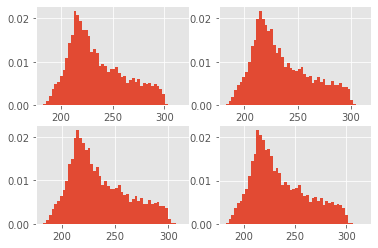

In [22]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, ax = plt.subplots(ncols=2, nrows=2) 
(values, bins, _) = ax[0,0].hist(TBP1,bins=50,density=True,label="TBP")
(values, bins, _) = ax[0,1].hist(TBC1,bins=50,density=True,label="TBC")
(values, bins, _) = ax[1,0].hist(T1,bins=50,density=True,label="T")
(values, bins, _) = ax[1,1].hist(TAP1,bins=50,density=True,label="TAP")

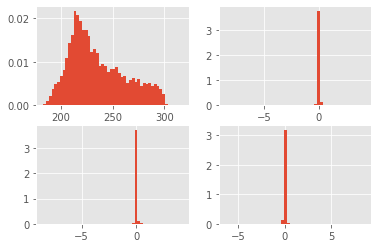

In [23]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, ax = plt.subplots(ncols=2, nrows=2) 
(values, bins, _) = ax[0,0].hist(TBP1,bins=50,density=True,label="TBP")
(values, bins, _) = ax[0,1].hist(TBC1-TBP1,bins=50,density=True,label="TBC-TBP")
(values, bins, _) = ax[1,0].hist(T1-TBP1,bins=50,density=True,label="T-TBP")
(values, bins, _) = ax[1,1].hist(TAP1-TBP1,bins=50,density=True,label="TAP-TBP")